In [2]:
!pip install simpletransformers sklearn seaborn pandas

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import class_weight


from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn import metrics
from sklearn.utils import class_weight

import seaborn as sns
import html

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df= pd.read_csv("/content/drive/MyDrive/public_maps (1).csv")

In [7]:
recurring_defult_strings = df['idea_title'].value_counts()[:40].index
recurring_defult_strings

Index(['ENTER to add siblings', 'DEL to delete', 'TAB to insert (Mac OS)',
       '... and some great ideas too!', 'Get started!',
       'Use toolbar to add ideas', 'Key shortcuts', 'INS to insert (Windows)',
       'We hope you\'ll have fun\nwith MindMeister ...',
       'Ideas for my novel ...', 'Welcome again!', 'My Geistesblitzes',
       'My First Mind Map', 'New node', 'All key shortcuts',
       'Check out \nhttp://www.mindmeister.com/services/tools/geistesblitz_widgets',
       'Drag &amp; Drop and double-click canvas',
       'Drag &amp; Drop and\rdouble-click canvas',
       'Find out more? Try http://www.mindmeister.com/help',
       'Email &amp; SMS Gateways', 'Geistesblitz Tools',
       'Find out more? Try\rhttp://www.mindmeister.com/help', 'Offline Mode',
       'Tools and Gadgets', 'Compare Editions', 'Get started now!', 'more...',
       'Meeting Minutes', 'Find out more?', 'Online Help', 'Project Plan',
       'Use Cases &amp; Templates', 'Personal Todo List', 'Vacat

Below, I have created a "text" feature, consisting of a concatenation of the "map_title" string and the "idea_title" strings associated with a given "map_id", using special separator tokens as outlined in the BERT paper to help the model identify sequence boundaries:

```
[CLS] Sentence A [SEP] Sentence B [SEP]
```

I tried both features individually - map_title or a concatenated string of idea_titles, and found the combination of the two to yield consistently improved performance (higher f1 and mcc scores in the K-fold cross validation check).


In [8]:
df_cleaned_idea_title = df[~df['idea_title'].isin(recurring_defult_strings)]
df_cleaned_idea_title['text'] = df_cleaned_idea_title.groupby("map_id")['idea_title'].transform(lambda x: ' [SEP] '.join(x)).drop_duplicates()
df_input = df_cleaned_idea_title.drop_duplicates("map_id").dropna(subset="text")
df_input = df_input[~df_input['map_category_name'].isin(["Life", "Productivity", "Entertainment"])] #drop "Life", "Productivity", "Entertainment" as discussed in EDA notebook

df_input['text'] = "[CLS] " + df_input['map_title'] + " [SEP] " + df_input['text'] + " [SEP]"
df_input['text'] = df_input['text'].str.replace(r'\\r|\\n', ' ', regex=True).replace(r"\\", "", regex=True).apply(lambda x: html.unescape(x)) #unescape html characters ad strip whitespace characters

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df_input['map_category_name'].factorize()[0]), y=df_input['map_category_name'].factorize()[0]).tolist()

df_input.head()

<ipython-input-8-75d4d29238a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_idea_title['text'] = df_cleaned_idea_title.groupby("map_id")['idea_title'].transform(lambda x: ' [SEP] '.join(x)).drop_duplicates()


,map_id,map_title,map_rating,map_category_name,idea_id,idea_parent_id,idea_title,text
13,149704,Firmenindex Smartdex,45,Business,149704,NaN,Jeff\'s friends,[CLS] Firmenindex Smartdex [SEP] Jeff\'s frien...
22,728945,WAW - Mensuração em\rMídias Sociais,50,Business,728945,NaN,"1C1_gestion_processus, de dossiers, de projets",[CLS] WAW - Mensuração em\rMídias Sociais [SEP...
73,828741,Rejestracja,30,Business,828741,NaN,Beat my depression,[CLS] Rejestracja [SEP] Beat my depression [SE...
86,836691,“The Importance of Display in the\rPrimary Cla...,50,Business,836691,NaN,Year 8 Revision,[CLS] “The Importance of Display in the\rPrima...
98,850983,&quot;Web copy that sells&quot;,50,Business,850983,NaN,DVD Specifications,[CLS] &quot;Web copy that sells&quot; [SEP] D...


I have chosen a pre-trained multilingual BERT model to handle the diversity of languages in the dataset. In addition to the language variety, since the dataset is limited in size, I hypothesise that a pre-trained model will lead to the best results.

In [125]:
def model_setup(class_weights, epochs=5, no_save=True):

  train_args = ClassificationArgs(
      use_multiprocessing=False,
      use_multiprocessing_for_evaluation=False,
      num_train_epochs=epochs,
      fp16=False,
      overwrite_output_dir=True,
      no_cache= True,
      no_save=no_save
  )

  # Create a ClassificationModel
  model = ClassificationModel(
      "bert", "bert-base-multilingual-cased",
      num_labels=4,
      args=train_args,
      use_cuda=True,
      weight=class_weights  #class weights to help the model address the class imbalance in the dataset
  )

  return model

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

Using stratified K-fold validation to account for the class imbalance and small dataset

In [66]:
folds = StratifiedKFold(n_splits=5, shuffle=True)

splits = folds.split(df_input["idea_title"], df_input["map_category_name"])
list_splits = list(splits)

K-fold validation loop below asseses the model's performance on unseen data by utilizing the available data more effectively

In [67]:
for train_idx, test_idx in list_splits:
  train_df = df_input.reset_index().loc[train_idx].rename(columns={"map_category_name":"pred_class"})[['pred_class','text']]
  train_df['pred_class'] = train_df['pred_class'].factorize()[0]

  test_df = df_input.reset_index().loc[test_idx].rename(columns={"map_category_name":"pred_class"})[['pred_class','text']]
  test_df['pred_class'] = test_df['pred_class'].factorize()[0]

  model = model_setup(class_weights,
                      epochs=1,
                      no_save=True
                      )


  model.train_model(train_df[["text", "pred_class"]],
                    f1=f1_multiclass,
                    acc=accuracy_score)


  result, model_outputs, wrong_predictions = model.eval_model(test_df[['text', 'pred_class']], f1=f1_multiclass, acc=accuracy_score)

  print("Training performance",  model.eval_model(train_df[['text', 'pred_class']], f1=f1_multiclass, acc=accuracy_score)[0], "\n\n")

  print("Test set performance", result, "\n\n")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Training performance {'mcc': 0.05653243231278006, 'f1': 0.415, 'acc': 0.415, 'eval_loss': 1.3433013677597045} 


Test set performance {'mcc': 0.02116621953863094, 'f1': 0.39215686274509803, 'acc': 0.39215686274509803, 'eval_loss': 1.3801377500806535} 




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

Training performance {'mcc': 0.024676533375674815, 'f1': 0.35323383084577115, 'acc': 0.35323383084577115, 'eval_loss': 1.337549457183251} 


Test set performance {'mcc': -0.010209525896878955, 'f1': 0.34, 'acc': 0.34, 'eval_loss': 1.3619766405650549} 




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

Training performance {'mcc': 0.1925759793334138, 'f1': 0.4577114427860697, 'acc': 0.4577114427860697, 'eval_loss': 1.3406738593028142} 


Test set performance {'mcc': -0.11528150115563851, 'f1': 0.28, 'acc': 0.28, 'eval_loss': 1.3684099401746477} 




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

Training performance {'mcc': 0.07713509879929019, 'f1': 0.31840796019900497, 'acc': 0.31840796019900497, 'eval_loss': 1.361436013992016} 


Test set performance {'mcc': 0.10723290190406207, 'f1': 0.32, 'acc': 0.32, 'eval_loss': 1.3749251195362635} 




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

Training performance {'mcc': 0.15057262711830427, 'f1': 0.4577114427860697, 'acc': 0.4577114427860697, 'eval_loss': 1.3227109083762536} 


Test set performance {'mcc': 0.07654655446197431, 'f1': 0.41999999999999993, 'acc': 0.42, 'eval_loss': 1.3667846747807093} 




**1st fold**

Training performance {'mcc': 0.05653243231278006, 'f1': 0.415, 'acc': 0.415, 'eval_loss': 1.3433013677597045} 

Test set performance {'mcc': 0.02116621953863094, 'f1': 0.39215686274509803, 'acc': 0.39215686274509803, 'eval_loss': 1.3801377500806535} 


**2nd fold**

Training performance {'mcc': 0.024676533375674815, 'f1': 0.35323383084577115, 'acc': 0.35323383084577115, 'eval_loss': 1.337549457183251} 

Test set performance {'mcc': -0.010209525896878955, 'f1': 0.34, 'acc': 0.34, 'eval_loss': 1.3619766405650549} 


**3rd fold**

Training performance {'mcc': 0.1925759793334138, 'f1': 0.4577114427860697, 'acc': 0.4577114427860697, 'eval_loss': 1.3406738593028142} 


Test set performance {'mcc': -0.11528150115563851, 'f1': 0.28, 'acc': 0.28, 'eval_loss': 1.3684099401746477} 

**4th fold**

Training performance {'mcc': 0.07713509879929019, 'f1': 0.31840796019900497, 'acc': 0.31840796019900497, 'eval_loss': 1.361436013992016} 


Test set performance {'mcc': 0.10723290190406207, 'f1': 0.32, 'acc': 0.32, 'eval_loss': 1.3749251195362635} 

**5th fold**

Training performance {'mcc': 0.15057262711830427, 'f1': 0.4577114427860697, 'acc': 0.4577114427860697, 'eval_loss': 1.3227109083762536} 


Test set performance {'mcc': 0.07654655446197431, 'f1': 0.41999999999999993, 'acc': 0.42, 'eval_loss': 1.3667846747807093}   

<br>
<br>


The accuracy metrics are generally poor (F1 in the range 0.2-0.45, and MCC 0-0.2). Using one epoch resulted in less model variance (overfitting).

In [133]:
idx = df_input[["map_id", "idea_id", "map_category_name"]].dropna().index
idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle=True, random_state=40, stratify=df_input[["map_category_name"]])  #Stratifies the train/test split to account for class imbalance

In [134]:
train_df_final = df_input.loc[idx_train].rename(columns={"map_category_name":"pred_class"})[['pred_class','text']]

labels = train_df_final['pred_class'].factorize()[1]
train_df_final['pred_class'] = train_df_final['pred_class'].factorize()[0]

In [135]:
test_df_final['pred_class'] = test_df_final['pred_class'].factorize()[0]

In [136]:
final_model = model_setup(class_weights, epochs=1, no_save=False)
final_model.train_model(train_df_final[["text", "pred_class"]])
result, model_outputs, wrong_predictions = final_model.eval_model(test_df_final[['text', 'pred_class']], f1=f1_multiclass, acc=accuracy_score)
result

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

{'mcc': 0.05297571713847396,
 'f1': 0.3137254901960784,
 'acc': 0.3137254901960784,
 'eval_loss': 1.372943333217076}

In [137]:
predictions, raw_outputs = final_model.predict(test_df['text'].tolist())

  0%|          | 0/7 [00:00<?, ?it/s]

# Confusion Matrix

In [140]:
mat = metrics.confusion_matrix(test_df['pred_class'], predictions, labels=range(0, len(labels)))


<Axes: >

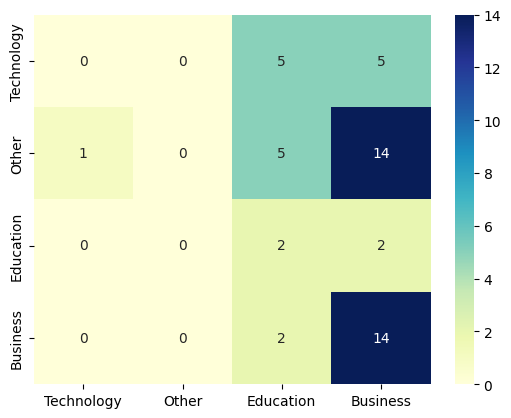

In [141]:
sns.heatmap(mat, robust=True, cmap="YlGnBu", annot=True, xticklabels=labels, yticklabels=labels)


Analysis:

The overall performance is poor, with the model biasing the Business class.

Numerous factors contribute to the poor performance. The data consist of only 251 unique map ids (after dropping the "Life", "Productivity" and "Entertainment" categories due to the low number of observations. The presence of multiple languages further dilutes the input data, making it more challenging to model the linguistic patterns for the purpose of classifying the category.


In [21]:
!zip -r /content/outputs.zip /content/outputs


  adding: content/outputs/ (stored 0%)
  adding: content/outputs/checkpoint-78-epoch-3/ (stored 0%)
  adding: content/outputs/checkpoint-130-epoch-5/ (stored 0%)
  adding: content/outputs/tokenizer_config.json (deflated 42%)
  adding: content/outputs/checkpoint-52-epoch-2/ (stored 0%)
  adding: content/outputs/special_tokens_map.json (deflated 42%)
  adding: content/outputs/training_args.bin (deflated 49%)
  adding: content/outputs/vocab.txt (deflated 45%)
  adding: content/outputs/config.json (deflated 55%)
  adding: content/outputs/eval_results.txt (deflated 28%)
  adding: content/outputs/pytorch_model.bin (deflated 7%)
  adding: content/outputs/model_args.json (deflated 62%)
  adding: content/outputs/tokenizer.json (deflated 67%)
  adding: content/outputs/checkpoint-26-epoch-1/ (stored 0%)
  adding: content/outputs/checkpoint-125-epoch-5/ (stored 0%)
  adding: content/outputs/checkpoint-104-epoch-4/ (stored 0%)
  adding: content/outputs/checkpoint-25-epoch-1/ (stored 0%)
  adding: c

In [22]:
from google.colab import files
files.download("/content/outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>